<a href="https://colab.research.google.com/github/meng19951027/OUC-/blob/main/Random%20forest%20for%20predicting%20N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
import seaborn as sns
sns.set(font= "Times new roman",style="ticks",font_scale=1.2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [21]:
df_all=pd.read_excel(r'/content/drive/MyDrive/F-NF.xlsx',sheet_name=5)
df_all.head()

,Q,hD,gamma,N,Type
0,0.000000,0.000,0.0,0.000000,No full
1,2514.951184,0.125,0.0,5.029902,No full
2,3189.759114,0.250,0.0,6.379518,No full
3,3620.178274,0.375,0.0,7.240357,No full
4,3829.829834,0.500,0.0,7.659660,No full


In [22]:
df_all.describe()

,Q,hD,gamma,N
count,9589.000000,9589.000000,9589.00000,9589.000000
mean,14222.235039,24.974168,0.15013,14.422084
std,5918.042631,14.462988,0.11186,2.115338
min,0.000000,0.000000,0.00000,0.000000
25%,8125.117805,12.500000,0.10000,13.330903
50%,14646.373724,25.000000,0.20000,14.825077
75%,19184.651330,37.500000,0.30000,15.847939
max,25590.816524,50.000000,0.30000,17.625697


In [ ]:
des=df_all.describe()
des.to_excel('describe.xlsx', sheet_name='Sheet1', index=True,header=True)

In [ ]:
dfx_corr=df_all.corr()

In [ ]:
dfx_corr

,Q,hD,gamma,N
Q,1.000000,0.192882,0.097616,0.148811
hD,0.192882,1.000000,-0.002423,0.535619
gamma,0.097616,-0.002423,1.000000,0.274529
N,0.148811,0.535619,0.274529,1.000000


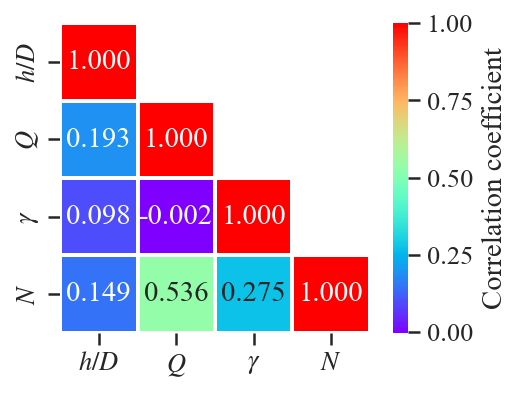

In [ ]:
import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=(4,3))
mask2=np.tri(dfx_corr.shape[0],dfx_corr.shape[1],k=-1)
for i,j in enumerate([dfx_corr]):
    j.columns=[r'$h/D$',r'$Q$',r'$\gamma$',r'$N$']
    j.index=[r'$h/D$',r'$Q$',r'$\gamma$',r'$N$']
    sns.heatmap(j,mask=mask2.T,annot=True,cmap='rainbow',lw=2,fmt=".3f"
                 ,cbar_kws={"label": "Correlation coefficient"},ax=ax)
    ax.set_aspect('equal')
plt.tight_layout()
fig.savefig(r'correlation.png',dpi=300,bbox_inches='tight')

**1. 数据划分**

In [ ]:
np.random.seed(0)
X=df_all.iloc[:,:3]
Y=df_all.iloc[:,3]
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.3,random_state=0)

In [ ]:
param_grid={'min_samples_leaf':np.arange(1, 1+10, 1)}
rfs = RandomForestRegressor(n_estimators=31
                             ,random_state=0
                            )
GS = GridSearchCV(rfs,param_grid,cv=10)
GS.fit(xtrain,ytrain)
print(GS.best_params_)
print(GS.best_score_)
min_leaf=GS.cv_results_[ 'mean_test_score']
leaf_para=np.arange(1, 1+10, 1)
np.savetxt(r'min_leaf.txt',np.concatenate((leaf_para.reshape(-1,1)
                                           ,min_leaf.reshape(-1,1))
                                           ,axis=1)
                                          )

{'min_samples_leaf': 1}
0.9982014069731893


In [ ]:
from sklearn.metrics import *
num_est=np.arange(1,211,10)
R2=np.zeros_like(num_est,dtype='float')
RMSE=np.zeros_like(num_est,dtype='float')
MAE=np.zeros_like(num_est,dtype='float')
for i,j in enumerate(num_est):
    rfs=RandomForestRegressor(n_estimators=j,random_state=0)
    scores=cross_val_score(rfs,xtrain,ytrain,cv=10,n_jobs=4)
    R2[i]=scores.mean()
    rmse=cross_val_score(rfs,xtrain,ytrain,cv=10,n_jobs=4,scoring='neg_root_mean_squared_error')
    RMSE[i]=rmse.mean()
    mae=cross_val_score(rfs,xtrain,ytrain,cv=10,n_jobs=4,scoring='neg_mean_absolute_error')
    MAE[i]=mae.mean()
print(np.max(R2),np.argmax(R2)*10+1)
C_D=np.concatenate((R2.reshape(-1,1),RMSE.reshape(-1,1),MAE.reshape(-1,1)),axis=1)
np.savetxt(r'cross_val_result.txt',C_D)

0.9982014069731893 31


In [ ]:
scorel = []
for i in range(25,36):
    rfs = RandomForestRegressor(n_estimators=i,
                                 n_jobs=4,
                                 random_state=0)
    score = cross_val_score(rfs,xtrain,ytrain,cv=10).mean()
    scorel.append(score)
print(max(scorel),([*range(25,36)][scorel.index(max(scorel))]))
np.savetxt(r'AC_25_36.txt',np.array(scorel).reshape(-1,1))

0.9982014069731893 31


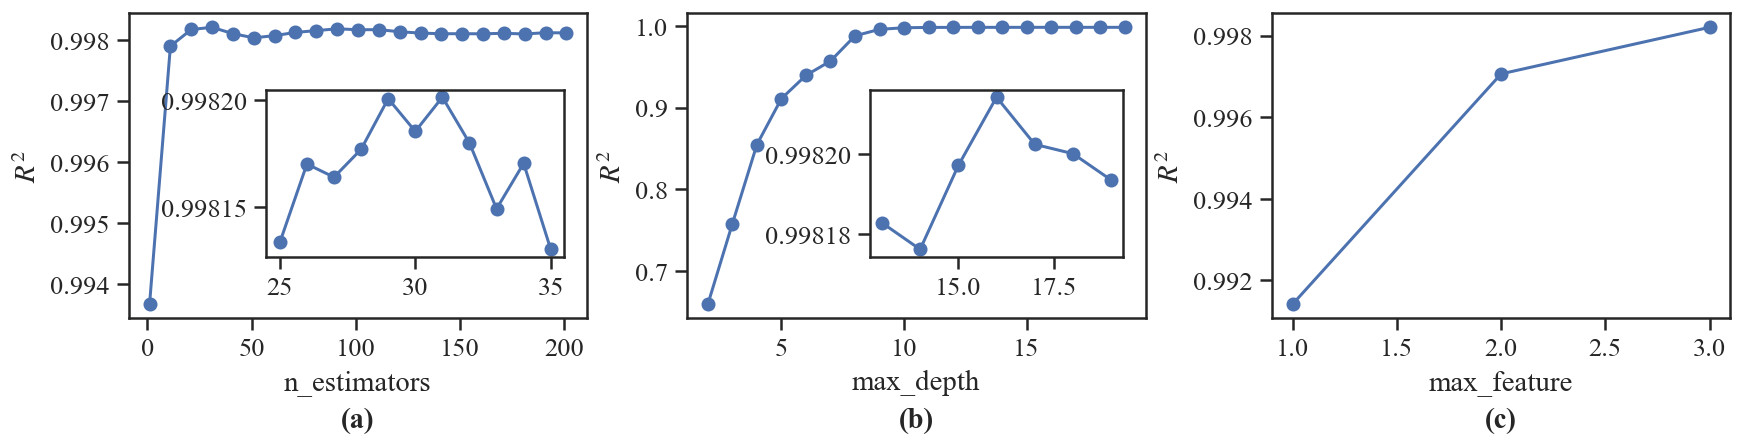

In [ ]:
num_est=np.arange(1,211,10)
cross_val_result=np.loadtxt(r'cross_val_result.txt')
LARGE=np.loadtxt(r'AC_25_36.txt')
max_dep=np.loadtxt(r'max_depth.txt')
max_fea=np.loadtxt(r'max_feature.txt')
fig,ax=plt.subplots(1,3,figsize=(12,3), layout='constrained')
p1,=ax[0].plot(num_est,cross_val_result[:,0],'-bo',label='Accuracy')
ax[0].set_ylabel(r'$R^2$')
ax[0].set_xlabel(r'n_estimators')
axins = ax[0].inset_axes([0.3, 0.2, 0.65,0.55])
axins.plot(range(25,36),LARGE,'-o')
axins.ticklabel_format(style='plain', axis='y')
axins.yaxis.set_major_formatter(plt.FormatStrFormatter('%.5f'))
ax[1].plot(max_dep[:,0],max_dep[:,1],'-bo')
axins1 = ax[1].inset_axes([0.4, 0.2, 0.55,0.55])
axins1.plot(max_dep[:,0][11:],max_dep[:,1][11:],'-bo')
ax[1].set_ylabel(r'$R^2$')
ax[1].set_xlabel(r'max_depth')
ax[2].plot(max_fea[:,0],max_fea[:,1],'-bo')
ax[2].set_ylabel(r'$R^2$')
ax[2].set_xlabel(r'max_feature')
nub=[r'(a)',r'(b)',r'(c)']
for i in range(3):
    ax[i].set_title(nub[i],y=-0.4,fontweight='bold')
plt.savefig(r'hyperparameter.png',dpi=300,bbox_inches='tight')
plt.show()

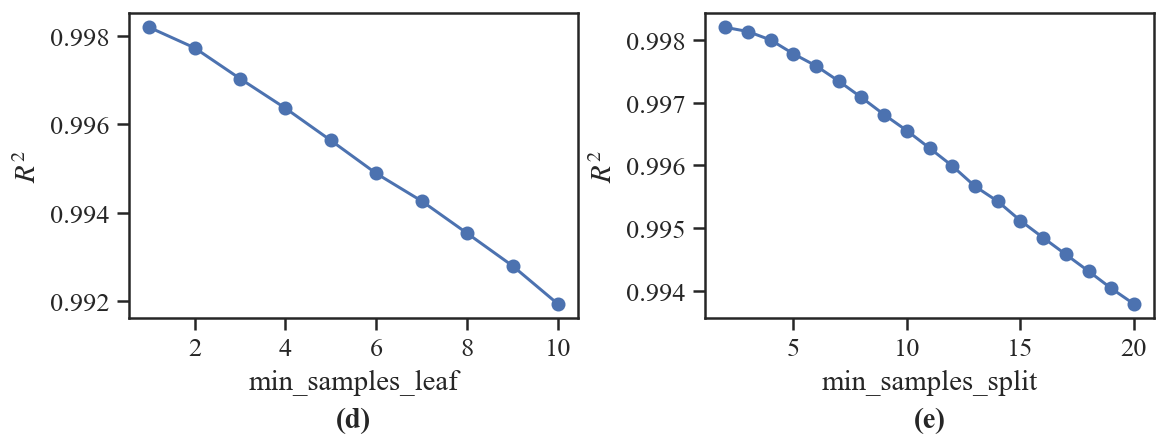

In [ ]:
min_leaf=np.loadtxt(r'min_leaf.txt')
min_split=np.loadtxt(r'min_split.txt')
fig,ax=plt.subplots(1,2,figsize=(8,3), layout='constrained')
p1,=ax[0].plot(min_leaf[:,0],min_leaf[:,1],'-bo',label='Accuracy')
ax[0].set_ylabel(r'$R^2$')
ax[0].set_xlabel(r'min_samples_leaf')
ax[1].plot(min_split[:,0],min_split[:,1],'-bo')
ax[1].set_ylabel(r'$R^2$')
ax[1].set_xlabel(r'min_samples_split')
nub=[r'(d)',r'(e)']
for i in range(2):
    ax[i].set_title(nub[i],y=-0.4,fontweight='bold')
plt.savefig(r'hyperparameter_leaf_split.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
rfs = RandomForestRegressor(n_estimators=31,random_state=3,max_depth=16,max_features=3)
tr_fold_score=cross_val_score(rfs,xtrain,ytrain,cv=10,n_jobs=4,scoring='r2')
te_fold_score=cross_val_score(rfs,xtest,ytest,cv=10,n_jobs=4,scoring='r2')
optimu_tr_ts=np.concatenate((tr_fold_score.reshape(-1,1),te_fold_score.reshape(-1,1))
                            ,axis=1)
np.savetxt(r'optimu_tr_ts.txt',optimu_tr_ts)

0.9981745042608152
0.9957998959167373


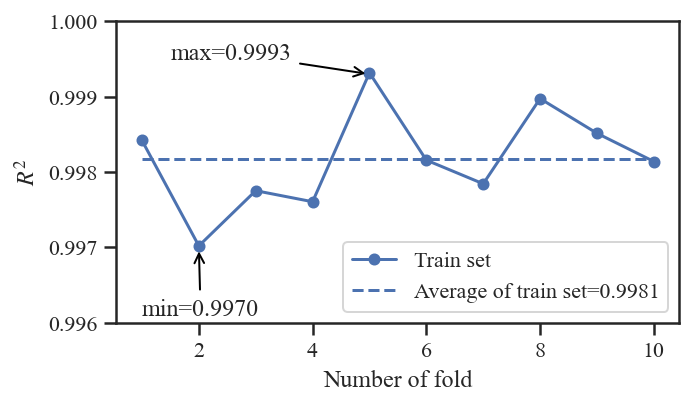

In [ ]:
fig=plt.figure(figsize=(5,3))
optimu_tr_ts=np.loadtxt(r'optimu_tr_ts.txt')
plt.plot(range(1,11),optimu_tr_ts[:,0],'-bo',label='Train set',ms=5)
tr_score_pre = optimu_tr_ts[:,0].mean()
plt.plot([1,10],[tr_score_pre,tr_score_pre],'--b',label='Average of train set'+'='+str(tr_score_pre)[:6])
print(tr_score_pre)
te_score_pre = optimu_tr_ts[:,1].mean()
print(te_score_pre)
plt.xlabel(r'Number of fold')
plt.ylabel(r'$R^2$')
plt.legend(loc='lower right')
plt.annotate(r'max='+str(np.max(optimu_tr_ts[:,0]))[:6],xy=(5,0.9993),xytext=(1.5,0.9995)
             ,arrowprops={"arrowstyle":'->',"color":'black'},xycoords='data')
plt.annotate(r'min='+str(np.min(optimu_tr_ts[:,0]))[:6],xy=(2,0.997),xytext=(1.0,0.9961)
             ,arrowprops={"arrowstyle":'->',"color":'black'},xycoords='data')
plt.ylim(0.996,1)
plt.tight_layout()
plt.savefig(r'10_fold.png',dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
rfs = RandomForestRegressor(n_estimators=31,random_state=1,max_depth=16,max_features=3)
rfs.fit(xtrain,ytrain)
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
ytr_pre=rfs.predict(xtrain)
yte_pre=rfs.predict(xtest)
print(r2_score(ytrain,ytr_pre))
print(r2_score(ytest,yte_pre))
print(mean_squared_error(ytrain,ytr_pre,squared=False))
print(mean_squared_error(ytest,yte_pre,squared=False))
print(mean_absolute_error(ytrain,ytr_pre))
print(mean_absolute_error(ytest,yte_pre))
rfs_all = RandomForestRegressor(n_estimators=31,random_state=1,max_depth=16,max_features=3)
rfs_all.fit(X,Y)
print(r2_score(Y,rfs_all.predict(X)))
print(mean_squared_error(Y,rfs_all.predict(X),squared=False))
print(mean_absolute_error(Y,rfs_all.predict(X)))

In [ ]:
rfs = RandomForestRegressor(n_estimators=31,random_state=1,max_depth=16,max_features=3)
rfs.fit(xtrain,ytrain)
print(rfs.score(xtrain,ytrain),'\n',rfs.score(xtest,ytest))

0.9997294371144652 
 0.9979342811829783


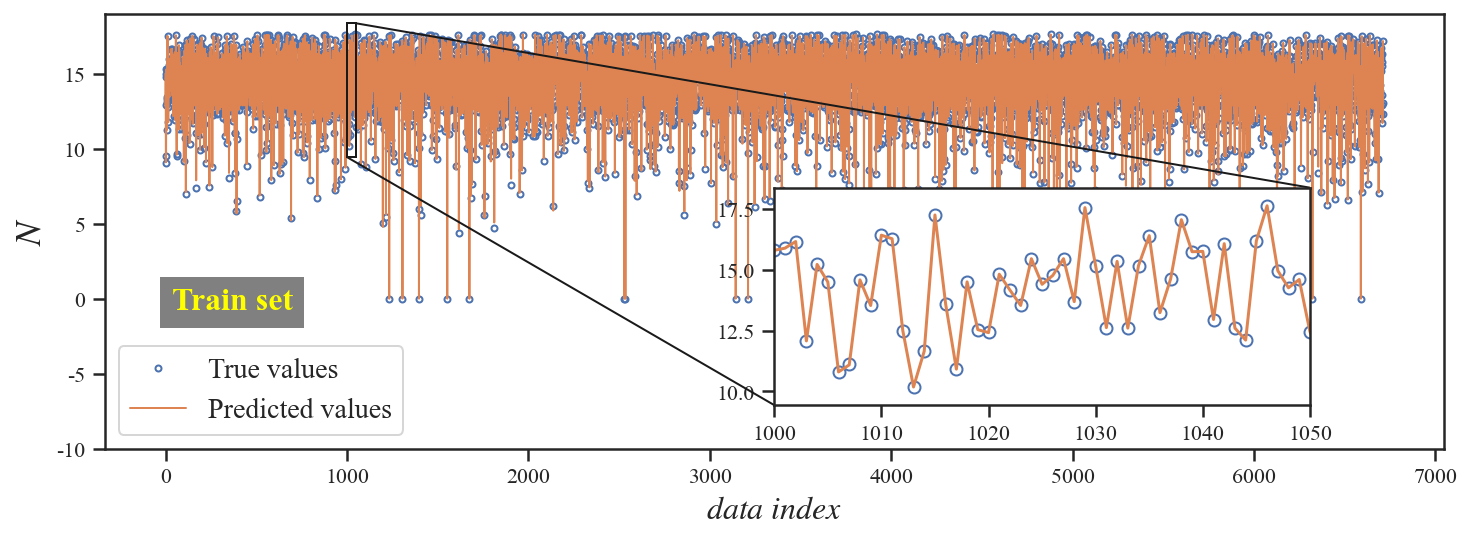

In [ ]:
plt.figure(1,figsize=(12,4))
x=range(len(xtrain))
plt.plot(x,ytrain.ravel(),'o',label='True values',mfc='none',mec='b',ms=3)
plt.plot(rfs.predict(xtrain),label='Predicted values',lw=1)
ax1=plt.gca()
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = ax1.inset_axes((0.5, 0.1, 0.4, 0.5))
axins.plot(x,ytrain.ravel(),'o',mfc='none',mec='b')
axins.plot(rfs.predict(xtrain))
zone_left = 1000;zone_right = 1050;y_ratio = 0.1
xlim0 = x[zone_left]
xlim1 = x[zone_right]
y_1=ytrain.ravel()
y_2=rfs.predict(xtrain)
y = np.hstack((y_1[zone_left:zone_right], y_2[zone_left:zone_right]))
ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax1, axins, loc1=3, loc2=1, fc="none", ec='k', lw=1,zorder=2)
ax1.set_ylim(-10,19)
ax1.text(0.05,0.32,'Train set',transform=ax1.transAxes,backgroundcolor='grey',color='yellow',fontweight='bold',fontsize=16)
ax1.set_xlabel(r'$data\ index$',fontsize=16)
ax1.set_ylabel(r'$N$',fontsize=18)
ax1.legend(loc='lower left',fontsize=14)
plt.savefig('rfs_train.png',dpi=300,bbox_inches='tight')
plt.show()

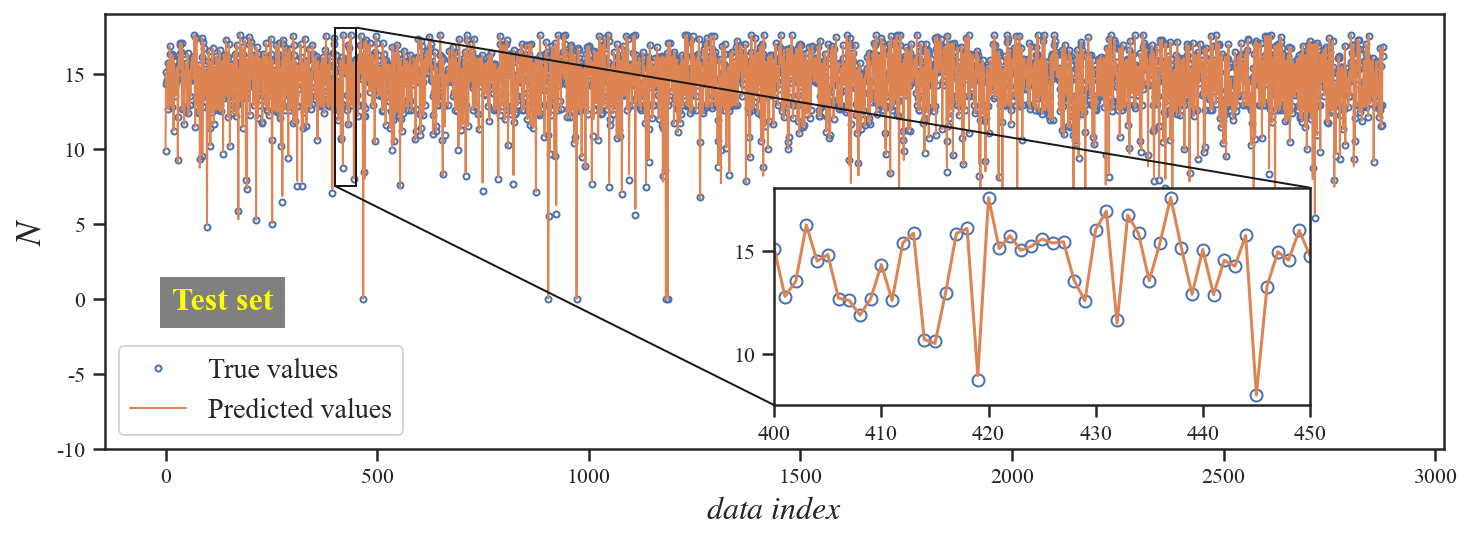

In [ ]:
plt.figure(2,figsize=(12,4))
x=range(len(xtest))
plt.plot(ytest.ravel(),'o',label='True values',mfc='none',mec='b',ms=3)
plt.plot(rfs.predict(xtest),label='Predicted values',lw=1)
ax2=plt.gca()
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = ax2.inset_axes((0.5, 0.1, 0.4, 0.5))
axins.plot(x,ytest.ravel(),'o',mfc='none',mec='b')
axins.plot(rfs.predict(xtest))
zone_left = 400
zone_right = 450
y_ratio = 0.05
xlim0 = x[zone_left]
xlim1 = x[zone_right]
y_1=ytest.ravel()
y_2=rfs.predict(xtest)
y = np.hstack((y_1[zone_left:zone_right], y_2[zone_left:zone_right]))
ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
ax2.set_ylim(-10,19)
mark_inset(ax2, axins, loc1=3, loc2=1, fc="none", ec='k', lw=1,zorder=2)
ax2.text(0.05,0.32,'Test set',transform=ax2.transAxes,backgroundcolor='grey',color='yellow',fontweight='bold',fontsize=16)
ax2.legend(loc='lower left',fontsize=14)
ax2.set_xlabel(r'$data\ index$',fontsize=16)
ax2.set_ylabel(r'$N$',fontsize=18)
plt.savefig('rfs_test.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
error_train=rfs.predict(xtrain)-ytrain
error_test=rfs.predict(xtest)-ytest

In [ ]:
AE=np.abs(error_test)
AETR=np.abs(error_train)
print(np.mean(AE))
print(np.mean(AETR))

0.017457024752899414
0.006523064009806282


In [ ]:
def error_anal(True_value,Pre_value,error_value,lab,svn):
    fig,ax=plt.subplots(1,2,figsize=(10,3.5),gridspec_kw={"width_ratios": [1,2]})
    ax[0].scatter(True_value,Pre_value,edgecolors='g',facecolor='none',label=r'$N$',s=30)
    ax[0].plot([0,18],[0,18],color='red',label=r'$y=x$')
    ax[0].set_xlabel(r'True values');ax[0].set_ylabel(r'Predicted values')
    ax[0].text(0.1,0.85,lab,transform=ax[0].transAxes
               ,backgroundcolor='grey',color='yellow',fontweight='bold',fontsize=14)
    ax[0].set_xlim(0,18)
    ax[0].set_ylim(0,18)
    ax[0].plot([0,18],[0,18-18*0.1],'--k')
    ax[0].plot([0,18],[0,18+18*0.1],'--k',label='1% error')
    ax[0].legend(loc='lower right')
    from matplotlib.pyplot import MultipleLocator
    y_major_locator=MultipleLocator(5)
    ax[0].yaxis.set_major_locator(y_major_locator)

    bins=ax[1].hist(error_value,20,edgecolor='k')
    print(bins)
    ax[1].set_xlabel(r'Absolute error')
    ax[1].set_ylabel(r'Count')

    axins1 = ax[1].inset_axes((0.23, 0.28, 0.42,0.6))
    axins2 = ax[1].inset_axes((0.8, 0.2, 0.15, 0.7))
    from scipy import stats
    res_freq = stats.relfreq(error_value, numbins=20)
    cdf_value = np.cumsum(res_freq.frequency)
    x=res_freq.lowerlimit+np.linspace(0,res_freq.binsize*res_freq.frequency.size,res_freq.frequency.size)
    axins1.plot(x,cdf_value*100,'-b',lw=1.5)
    print(x,cdf_value*100)
    axins1.set_xlabel(r'Absolute error')
    axins1.set_ylabel(r'CDF(%)')
    axins1.plot([0.176,0.176],[np.min(cdf_value*100),np.max(cdf_value*100)],'--r')
    axins2.boxplot(error_value,0,labels=[r'RF'], widths=0.5, flierprops={'markersize': 3,"markerfacecolor":'red'})
    axins2.set_ylabel(r'Absolute error')
    plt.tight_layout()
    plt.savefig(svn,dpi=300,bbox_inches='tight')
    plt.show()

(array([6.499e+03, 9.400e+01, 3.600e+01, 3.000e+01, 1.600e+01, 8.000e+00,
       5.000e+00, 8.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
       2.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       1.000e+00, 1.000e+00]), array([0.        , 0.04150068, 0.08300137, 0.12450205, 0.16600274,
       0.20750342, 0.2490041 , 0.29050479, 0.33200547, 0.37350616,
       0.41500684, 0.45650752, 0.49800821, 0.53950889, 0.58100958,
       0.62251026, 0.66401094, 0.70551163, 0.74701231, 0.788513  ,
       0.83001368]), <BarContainer object of 20 artists>)
[-0.02184247  0.02414167  0.07012581  0.11610995  0.16209408  0.20807822
  0.25406236  0.3000465   0.34603063  0.39201477  0.43799891  0.48398305
  0.52996718  0.57595132  0.62193546  0.6679196   0.71390373  0.75988787
  0.80587201  0.85185615] [ 95.23241955  97.80989273  98.62932062  99.04648391  99.37425507
  99.55303933  99.64243147  99.76162098  99.80631704  99.8659118
  99.88081049  99.91060787  99.91060787  99.910

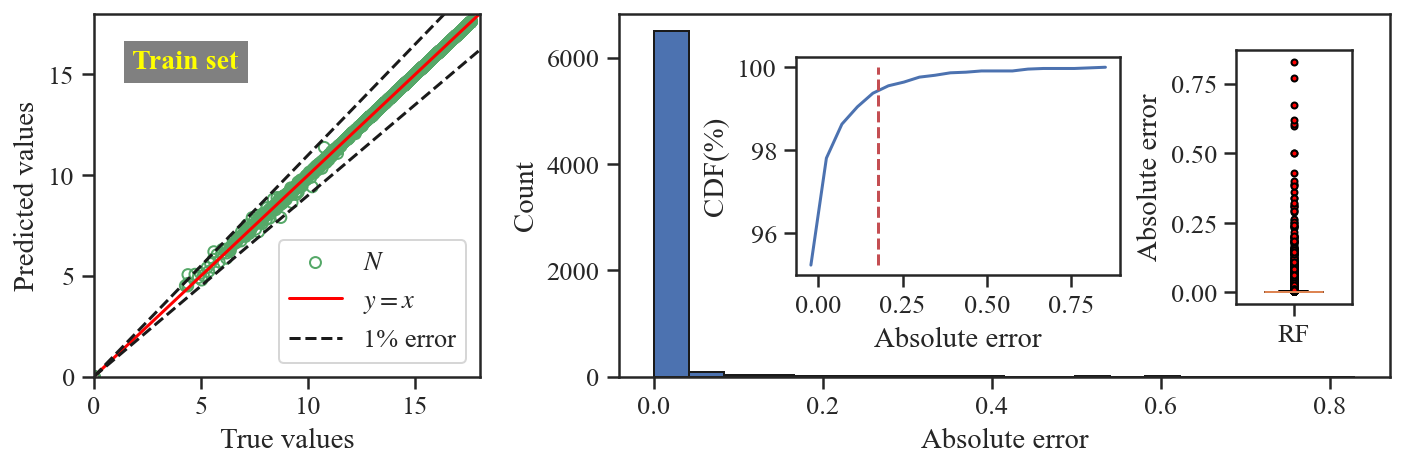

In [ ]:
error_anal(ytrain.ravel(),rfs.predict(xtrain),np.abs(error_train),r'Train set',r'train_error.png')

(array([2.782e+03, 4.600e+01, 1.300e+01, 1.000e+01, 4.000e+00, 1.100e+01,
       3.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 1.000e+00]), array([0.        , 0.11075779, 0.22151557, 0.33227336, 0.44303115,
       0.55378894, 0.66454672, 0.77530451, 0.8860623 , 0.99682009,
       1.10757787, 1.21833566, 1.32909345, 1.43985123, 1.55060902,
       1.66136681, 1.7721246 , 1.88288238, 1.99364017, 2.10439796,
       2.21515574]), <BarContainer object of 20 artists>)
[-0.05829357  0.06442974  0.18715305  0.30987636  0.43259967  0.55532298
  0.67804629  0.8007696   0.92349291  1.04621622  1.16893953  1.29166284
  1.41438615  1.53710946  1.65983277  1.78255608  1.90527939  2.0280027
  2.15072601  2.27344932] [ 95.34237052  97.81021898  98.60966284  98.99200556  99.20055613
  99.58289885  99.68717414  99.82620786  99.82620786  99.86096628
  99.89572471  99.89572471  99.89572471  99.930

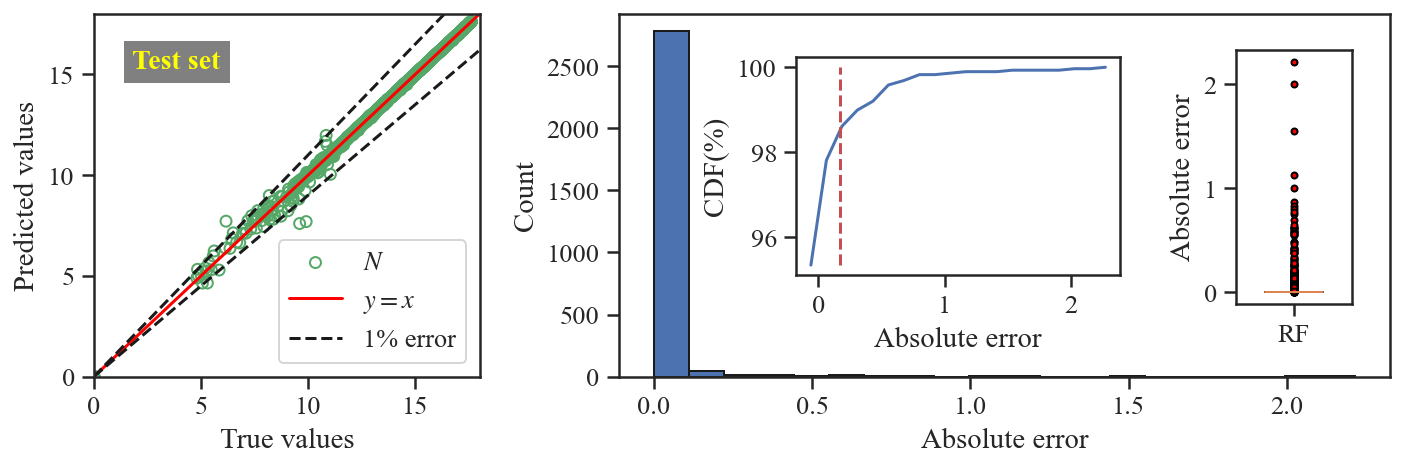

In [ ]:
error_anal(ytest.ravel(),rfs.predict(xtest),np.abs(error_test),r'Test set',r'test_error.png')

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
Train_MC_three=np.zeros((200,3))
Test_MC_three=np.zeros((200,3))
fea=[]
for i in range(200):
    xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.3)
    rfs = RandomForestRegressor(n_estimators=31,max_depth=16,max_features=3)
    rfs.fit(xtrain,ytrain)
    Train_MC_three[i,0]=rfs.score(xtrain,ytrain)
    Train_MC_three[i,1]=mean_squared_error(ytrain,rfs.predict(xtrain),squared=False)
    Train_MC_three[i,2]=mean_absolute_error(ytrain,rfs.predict(xtrain))

    Test_MC_three[i,0]=rfs.score(xtest,ytest)
    Test_MC_three[i,1]=mean_squared_error(ytest,rfs.predict(xtest),squared=False)
    Test_MC_three[i,2]=mean_absolute_error(ytest,rfs.predict(xtest))
    fea.append(rfs.feature_importances_)

In [ ]:
F=np.array(fea).reshape(-1,3)
np.savetxt(r'M_C_tr.txt',Train_MC_three)
np.savetxt(r'M_C_ts.txt',Test_MC_three)
np.savetxt(r'Feature_200.txt',F)

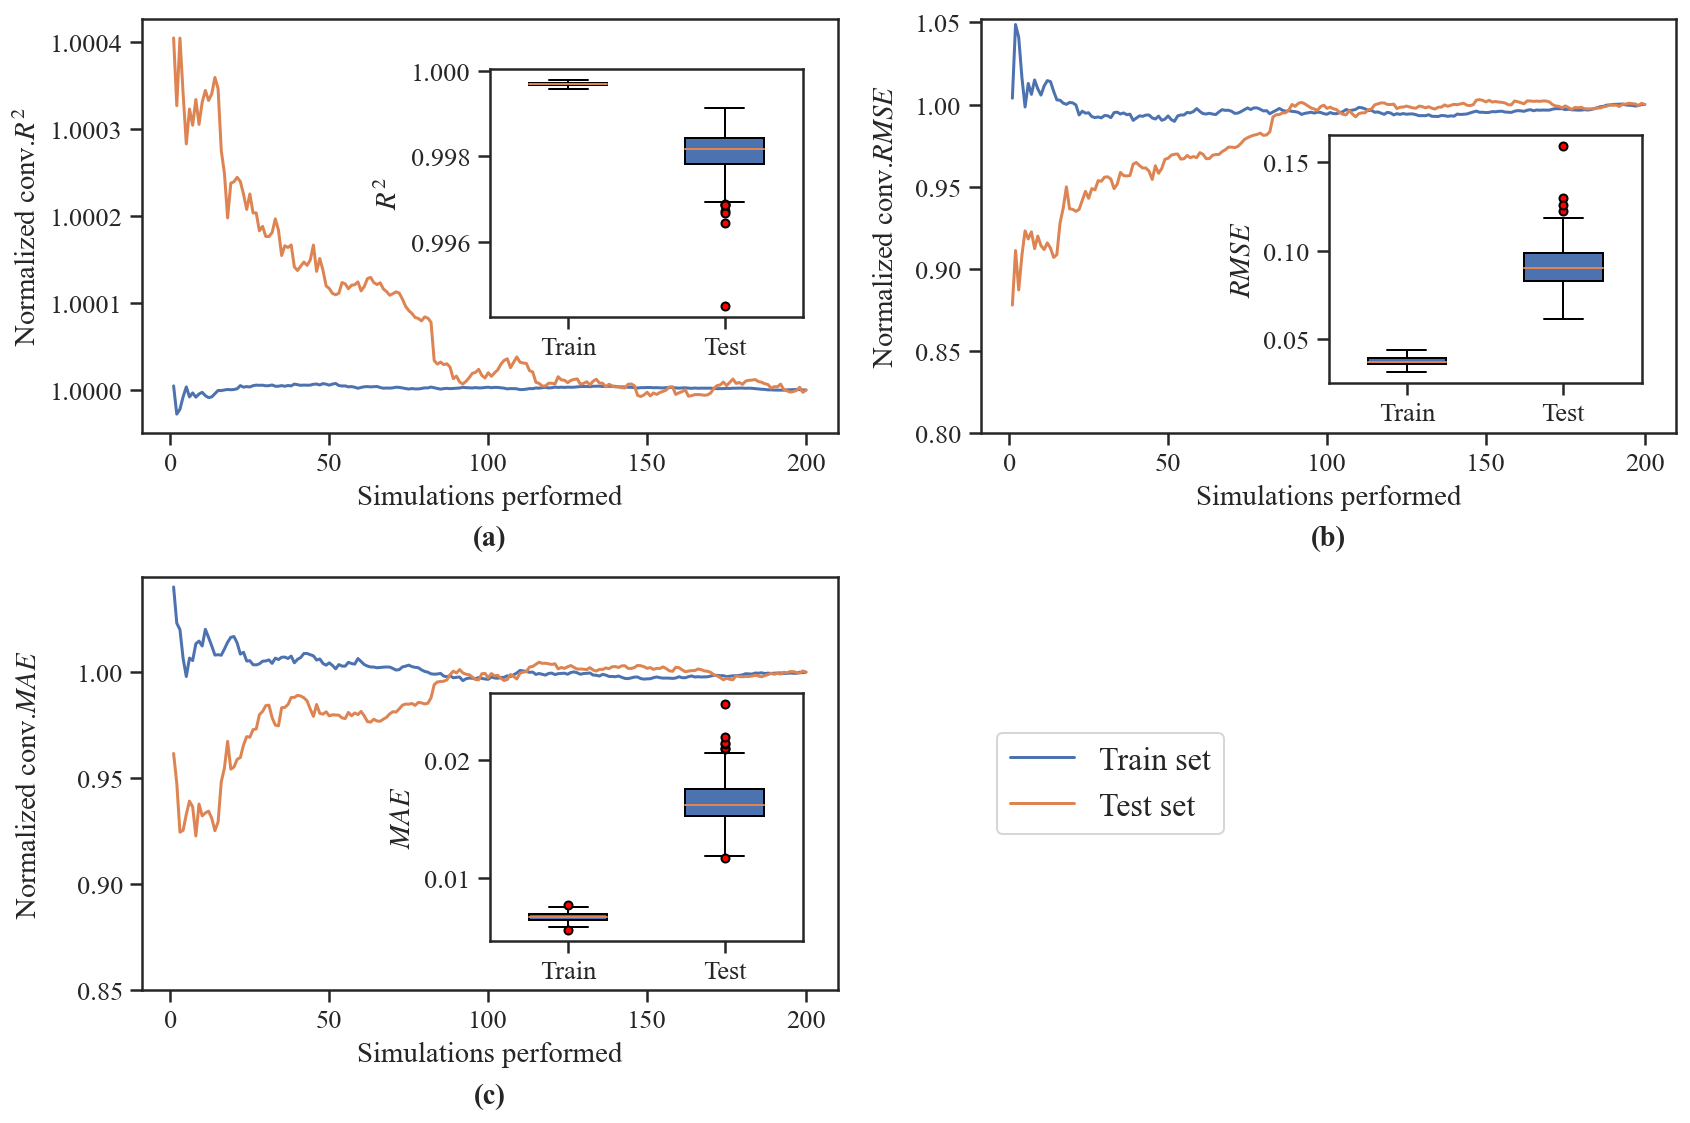

In [ ]:
import numpy as np
tr=np.loadtxt(r'M_C_tr.txt')
ts=np.loadtxt(r'M_C_ts.txt')
def mc_tr_ts(j,train,test):
    aa=[]
    bb=[]
    for i in range(1,201):
        aa.append(train[:,j][:i].mean())
        bb.append(test[:,j][:i].mean())
    return aa,bb
import matplotlib.pyplot as plt
fig,ax=plt.subplots(2,2,figsize=(12,8))
ylab=[r'Normalized conv.'+r'$R^2$',r'Normalized conv.'+r'$RMSE$',r'Normalized conv.'+r'$MAE$']
axins_ylab=[r'$R^2$',r'$RMSE$',r'$MAE$']
labels=['Train','Test']
nub=[r'(a)',r'(b)',r'(c)']
k=0
for i in range(2):
    for j in range(2):
        ax[i][j].plot(range(1,201),mc_tr_ts(k,tr,ts)[0]/tr.mean(axis=0)[k])
        ax[i][j].plot(range(1,201),mc_tr_ts(k,tr,ts)[1]/ts.mean(axis=0)[k])


        ax[i][j].set_xlabel(r'Simulations performed')
        ax[i][j].set_ylabel(ylab[k])
        ax[i][j].set_title(nub[k],y=-0.3,fontweight='bold')
        if k==0:
            axins= ax[i][j].inset_axes((0.5, 0.28, 0.45,0.6))
            bbb=np.concatenate((tr[:,k].reshape(-1,1),ts[:,k].reshape(-1,1)),axis=1)
            axins.boxplot(bbb,labels=labels,patch_artist=True, widths=0.5, flierprops={'markersize': 4,"markerfacecolor":'red'})
            axins.set_ylabel(axins_ylab[k])
        else:
            axins= ax[i][j].inset_axes((0.5, 0.12, 0.45,0.6))
            bbb=np.concatenate((tr[:,k].reshape(-1,1),ts[:,k].reshape(-1,1)),axis=1)
            axins.boxplot(bbb,labels=labels,patch_artist=True, widths=0.5, flierprops={'markersize': 4,"markerfacecolor":'red'})
            axins.set_ylabel(axins_ylab[k])

        k+=1
        if k>2:
            break
ax[0,0].ticklabel_format(style='plain', axis='y')
ax[0,0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax[0,1].set_ylim(0.8,1.052)
ax[1,0].set_ylim(0.85,1.045)
ax[1][1].plot([],[],label='Train set')
ax[1][1].plot([],[],label='Test set')
ax[1][1].legend(loc=6,fontsize=16)
ax[1][1].axis('off')
fig.align_ylabels()
plt.tight_layout()
plt.savefig(r'200_simulutions.png',dpi=300,bbox_inches='tight')
plt.show()